# This notebook references data from 3 sources:
- CMEMS hist048: https://data.marine.copernicus.eu/product/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/description
- The NAFC55 deployment spreadsheet
- The NAFC55 NetCDF data files from archive

# Summary:
- the CMEMS files only contain WMO ids (not Telecom IDs)
- the NAFC files only contain Telecom IDs (not WMO ids)
- the spreadsheet contains both, so I was able to compare them by comparing them each dataset to the spreadsheet individually.
 
# This is how I picked out which files overlapped between the two datasets:
 
1. I used the min/max times and coordinates in the CMEMS index_history.txt file to find all the files that had tracks that crossed into the test area (ie, the coordinates Heather sent) during the right time frame. Since the index file also had the full paths to the files themselves, I used this to compile a list of just the paths for the files that needed to be downloaded (instead of downloading the full global domain).
 
2. I opened up the Excel deployment spreadsheet that Vanessa sent and pulled out the WMO ids, then I also pulled the WMO ids from the CMEMS files by taking the appropriate section of the filenames. I compared these two lists to find which WMO ids show up in both. Also, see notebook Compare_NAFC55_and_hist048_WMO_IDs
 
3. Then I manually updated the spreadsheet to figure out which tracks were in the CMEMS dataset (using the WMO ids) and which tracks we had local files for (using the Telecom IDs).
 
4. I also went back and checked the entire global CMEMS dataset after the fact to be sure that I hadn't missed any WMO ids by only looking at the files in the test area. I hadn't missed any.
 
5. Since then, I've downloaded the relevant CMEMS datafiles and have compared a couple. I'm confident that I've correctly picked out the files that overlap (ie, CMEMS has the files that I expect it to and doesn't have the files that I don't expect it to have).

### Update (20231108): After adding 00 as the 3rd and 4th digits of the 5 digit WMO numbers, there seems to be an additional 12 tracks that are included in the CMEMS dataset!

### Begin by scrolling down until you reach the "The following only looks at tracks that appear in both the CMEMS data set and in our NAFC files" section

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from shapely.geometry import Point, Polygon
import xarray as xr
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import HTML
import cmd
import shutil
cli = cmd.Cmd()

# I pulled the following values from the spreadsheet:
included_teleids = list(map(str, [300234062853860, 300234062853860, 300234063512980, 300234063515680, 300234063516680, 
                                  300234063122470, 300234063123360, 300234063515630, 300234063518580, 300234063517970, 
                                  300234063514970, 300234063614000, 300234063265890, 300234063261890, 300234063263870, 
                                  300234063260870, 300234063263860, 300234063260860, 300234063260880, 300234063266850, 
                                  300234063261790, 300234063262880, 300234063264850, 300234063261880, 300234063262890, 
                                  300234063265840, 300234063268850, 300234063263890, 300234063265850, 300234063267860, 
                                  300234063262850, 300234063265870, 300234063268860, 300234063262860, 300234063264870, 
                                  300234063265880, 300234063269780, 300234063269870, 300234063269880, 300234063264890, 
                                  300234063265910, 300234063269840, 300234063266840, 300234063269850, 300234065005440, 
                                  300234065907190, 300234065901180, 300234065008440, 300234065001460, 300234063261890]))

included_wmoids = list(map(str, [4400670, 4400670, 4700539, 4700540, 4700549, 4700555, 4700560, 4700562, 4700567, 
                                 4700568, 4700569, 4700584, 4401601, 4401602, 4401603, 4401604, 4401605, 4401606, 
                                 4401607, 4401608, 4401609, 4401610, 4401611, 4401612, 4401613, 4401614, 4401616, 
                                 4401618, 4401619, 4401620, 4401622, 4401624, 4401625, 4401627, 4401628, 4401629, 
                                 4401630, 4401631, 4401632, 4401633, 4401634, 4401635, 4401636, 4401637, 4401800, 
                                 4401904, 4401905, 4701668, 4701669, 4401602]))

# note: 300234062458690 and 300234062551640 were not SVP drifters
excluded_teleids = list(map(str, [300234063511220, 300234063617000, 300234063129520, 
                                  300234063122550, 300234063125370, 300234063123370, 300234063121480, 300234063124480, 
                                  300234063122480, 300234063120370, 300234063266860, 300234063262840, 300234063267840, 
                                  300234063264840, 300234063263840, 300234065806830]))

# note: 4400671 and 4400672 were not SVP drifters
excluded_wmoids = list(map(str, [4700544, 5700546, 4700553, 4700554, 4700556, 4700557, 4700558, 
                                  4700559, 4700561, 4700574, 4401615, 4401617, 4401621, 4401623, 4401626, 4401903]))

drifter_dir = 'C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/'
cmems_dir = os.path.join(drifter_dir, 'CMEMS', 'updated_20231025')
hist048dir = os.path.join(cmems_dir,  'hist048', 'hist048_netcdf')
hist048_files = glob.glob(os.path.join(hist048dir, '*.nc'))
hist048_ftp_list = os.path.join(cmems_dir, "hist048_ftp-download-list_hdr.txt")

nafc55dir = os.path.join(drifter_dir, "nafc")
nafc55_raw_dir = os.path.join(nafc55dir, "raw")
nafc55_spreadsheet = os.path.join(nafc55dir, "nafc55_svp_deployments.csv")
nafc55_raw_files = glob.glob(os.path.join(nafc55_raw_dir, "*.drifter"))

# NAFC WMO ids
nafc_spreadsheet = pd.read_csv(nafc55_spreadsheet, encoding = "ISO-8859-1")
nafc_spreadsheet['Dep_Date_YYYY_MM_DD'] = pd.to_datetime(nafc_spreadsheet['Dep_Date_YYYY_MM_DD'].values)
nafc55_wmoids = [str(x) for x in list(nafc_spreadsheet['WMO_ID'])]
nafc55_teleids = [str(x) for x in list(nafc_spreadsheet['Telecom_ID'])]

# hist048 wmo ids (pulling from the list of names included in the ftp paths for download file)
ftp_list_df = pd.read_csv(hist048_ftp_list)
hist048_wmoids = [os.path.basename(str(x[0])).split('.')[0].split('_')[-1] for x in ftp_list_df.values]

# I used this and the lists above to copy the hist048 files that are in NAFC55 into a subfolder (netcdf_overlap)
def locate_files(wmoids, fnames):
    files_list = []
    for wmoid in wmoids:
        for name in fnames:
            if wmoid in name:
                files_list.append(name)
    return files_list

ftpnames = ftp_list_df.ftp_names.values        
included_files = locate_files(included_wmoids, ftpnames)
excluded_files = locate_files(excluded_wmoids, ftpnames)

nafcnames = glob.glob(os.path.join(os.path.join(nafc55dir, "netcdf"), "*.nc"))
nafc_included_files = locate_files(included_teleids, nafcnames)
nafc_excluded_files = locate_files(excluded_teleids, nafcnames)

## to copy the missing_from_cmems nafc files
#for fname in nafc_excluded_files:
#    shutil.copy(fname, os.path.join(overlap_dir, "missing_from_cmems"))

## to copy the nafc files that overlap with cmems
#for fname in nafc_included_files:
#    shutil.copy(fname, os.path.join(overlap_dir, "overlap_nafc"))

## to copy the cmems files that overlap with nafc
#for fname in included_files:
#    bname = os.path.basename(fname)
#    shutil.copy(os.path.join(hist048dir, bname), os.path.join(overlap_dir, "overlap_hist048"))
    
# dataset overlap:
overlap_dir = os.path.join(drifter_dir, "overlap")

def get_files_list(overlap_dir, subdir):
    files_overlap = glob.glob(
        os.path.join(os.path.join(overlap_dir, subdir), "*.nc")
    )
    return files_overlap

overlap_nafc_files = get_files_list(overlap_dir, "overlap_nafc")
overlap_cmems_files = get_files_list(overlap_dir, "overlap_hist048")
missing_from_cmems_files = get_files_list(overlap_dir, "missing_from_cmems")

In [2]:
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox', ('minlon', 'maxlon', 'minlat', 'maxlat'))
shelf_coords = LatLonBoundingBox(minlon=-90, maxlon=-30, minlat=35, maxlat=80)


def compare_lists(list1, list2):
    biglist = max([list1, list2], key=len)
    smlist = min([list1, list2], key=len)
    overlap = [x for x in biglist if x in smlist]
    outside = [x for x in biglist if x not in smlist]
    return overlap, outside


def display_deployments_by_year(df):
    depyrs = df.Dep_Date_YYYY_MM_DD.dt.year.value_counts(normalize=False).to_frame()
    print('\n\nDeployments by year:\n\n' + str(depyrs))
    
    
def determine_shelf_edges(shelf_coords):
    shelf_edges = [(shelf_coords.maxlon, shelf_coords.maxlat),
                   (shelf_coords.maxlon, shelf_coords.minlat),
                   (shelf_coords.minlon, shelf_coords.minlat),
                   (shelf_coords.minlon, shelf_coords.maxlat),
                   (shelf_coords.maxlon, shelf_coords.maxlat)]
    return shelf_edges


def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    if isinstance(x, np.ndarray):
        with np.errstate(invalid='ignore'):
            x_wrap = np.remainder(x, 360)
        x_wrap[x_wrap > 180] -= 360
        return x_wrap
    elif hasattr(x, "__len__"):
        return wrap_to_180(np.array(x))
    else:
        return wrap_to_180(np.array([x]))[0]  


def plot_tracks(df, tstr, shelf_coords, test_region=False, savedir=None):
       
    plt.figure(figsize=(20, 20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
    
    shelf_edges = determine_shelf_edges(shelf_coords)
    slons = list(zip(*shelf_edges))[0]
    slats = list(zip(*shelf_edges))[1]
    ax.plot(slons, slats, 'r-')
    
    for uniq in np.unique(df.filenames.values):
        trackdf = df.loc[df.filenames.values == uniq]
        trackdf_in = trackdf.loc[trackdf.pip.values]
        leglab = '_no_label_'
        if tstr == 'nafc55_tracks_not_in_hist048':
            leglab = uniq
        if not test_region:
            ax.plot(wrap_to_180(trackdf.lons.values), trackdf.lats.values, 'w-', markersize=1)
        ax.scatter(wrap_to_180(trackdf_in.lons.values), trackdf_in.lats.values, label=leglab, 
                   linestyle='None', linewidth=0, edgecolor='None', s=2)
        
    set_type = "Full data set domain"
    titlestr = (tstr + "\n" + set_type)
    if test_region:
        set_type = "Cropped to test region"
        titlestr = (tstr + "\n" + set_type)
        bounds = [shelf_coords.minlon - 2, shelf_coords.maxlon + 2,
                  shelf_coords.minlat - 2, shelf_coords.maxlat + 2]
        ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    plt.title(titlestr)
    plt.tight_layout()
    if tstr == 'nafc55_tracks_not_in_hist048':
        ax.legend(fontsize=12)
    if savedir is not None and os.path.isdir(savedir):
        figname = tstr + "_" + set_type.replace(" ", "_")
        #print('\n\nSaving ' + os.path.join(savedir, figname + '_20231030.png'))
        plt.savefig(os.path.join(savedir, figname + ".png"))

    plt.show()
    
    
def point_in_polygon(pt, poly):
    point = Point(pt)
    bool_within = point.within(poly) 
    #bool_contains = poly.contains(point)
    return(bool_within)


def grab_coords(ds, tstr=None):
    if tstr == "GDP":
        lons = wrap_to_180(ds.longitude.values)
        lats = ds.latitude.values
        time = ds.time.values
    else:
        lons = wrap_to_180(ds.LONGITUDE.values)
        lats = ds.LATITUDE.values
        time = ds.TIME.values
    return lons, lats, time


def create_pickle_file(picklefile, data):
    with open(picklefile,'wb') as f:
        pickle.dump(data, f)


def load_pickle_file(picklefile):
    with open(picklefile,'rb') as f:
        data = pickle.load(f)
    return data


def read_netcdf_file(fname):
    try:
        with xr.load_dataset(fname) as ds:
            return(ds)
    except:
        print('bad data: ', fname)
        return None
        

def load_drifter_dataset_dict(datafiles):
    dsdict = {}
    for file in datafiles:
        if read_netcdf_file(file) is not None:
            ds = read_netcdf_file(file)
            dsdict[os.path.basename(file)] = ds
    return dsdict

def load_drifter_datasets(datafiles, picklefile, use_pickle=True): 
    
    def load_from_pickle(picklefile):
        ds_dict = load_pickle_file(picklefile)
        return ds_dict
        
    def load_from_files(datafiles, picklefile):
        print('loading datasets from files and creating pickled list of datasets\n')
        ds_dict = load_drifter_dataset_dict(datafiles)
        create_pickle_file(picklefile, ds_dict)
        return ds_dict
    
    if use_pickle:
        try: 
            ds_dict = load_from_pickle(picklefile)
        except:
            ds_dict = load_from_files(datafiles, picklefile)
    else:
        ds_dict = load_from_files(datafiles, picklefile)
        
    return ds_dict


def summary_str(smval, bigval):
    perc = "{:.1f}".format((smval / bigval) * 100)
    percstr = (str(smval) + ' of ' + str(bigval) + ' points are in the region (' + str(perc) + '%)')
    return percstr
    
    
def exclude_by_outside_extremes(df, shelf_coords):
    df.loc[(df['lons'] < (shelf_coords.minlon)), 'pip'] = False 
    df.loc[(df['lons'] > (shelf_coords.maxlon)), 'pip'] = False
    df.loc[(df['lats'] < (shelf_coords.minlat)), 'pip'] = False
    df.loc[(df['lats'] > (shelf_coords.maxlat)), 'pip'] = False
    percstr = summary_str(len(df['pip'][df['pip'].values].values), 
                          len(df['pip'].values))
    return percstr, df
    
    
def exclude_by_outside_polygon(df, shelf_coords):
    shelf_edges = determine_shelf_edges(shelf_coords)
    df['temp'] = [point_in_polygon(point, Polygon(shelf_edges[0:4])) 
                  for point in zip(masterdf.lons.values, masterdf.lats.values)]
    df.loc[df['temp'] == False, 'pip'] = False    
    percstr = summary_str(len(df['pip'][df['pip'].values]), 
                          len(df['pip']))
    return percstr, df


def toss_outside(df, shelf_coords, exclude_type='fast'):
    if exclude_type == 'fast':
        percstr, df = exclude_by_outside_extremes(df, shelf_coords)
        print(percstr + ' after removing any points smaller or larger than test region extremes')
    
    if exclude_type == 'slow':
        percstr, df = exclude_by_outside_extremes(df, shelf_coords)
        print('\n', percstr + ' after removing any points smaller or larger than test region extremes')
        percstr, df = exclude_by_outside_polygon(df, shelf_coords)
        print(percstr + ' after also removing any points outside the test region polygon ' 
              + '(useful for irregularly shaped test regions)')
        
    return df
    
    
def create_master_df(ds_dict, tstr): 
    track_names = list(ds_dict.keys())
    #print('\nIncluding ' + str(len(track_names)) + ' drifter tracks\n')
    all_lons = []
    all_lats = []
    all_times = []
    all_idents = []
    for filename, ds in ds_dict.items():
        lons, lats, times = grab_coords(ds, tstr)
        all_lons.extend(lons)
        all_lats.extend(lats)
        all_times.extend(times)
        all_idents.extend([filename] * len(lons))

    masterdf = pd.DataFrame({
        'lons': all_lons,
        'lats': all_lats,
        'times': all_times,
        'filenames': all_idents,
        'pip': [True] * len(all_lons)
    })
    return masterdf


def determine_points_per_year(df):
    # to count within bins, use value_counts(bins=num_of_bins)
    ppy = pd.to_datetime(df['times']).dt.year.value_counts(normalize=False)  
    ppy_rel = pd.to_datetime(df['times']).dt.year.value_counts(normalize=True)
    countdf = pd.DataFrame()
    countdf['year'] = ppy.index.tolist()
    countdf['pts_inside'] = ppy.tolist()
    countdf['rel_freq'] = ["{:.2f}".format(relfreq) for relfreq in ppy_rel.tolist()]
    display(HTML(countdf.to_html(index=False)))
    return ppy

############################################################################################
def determine_tracks_per_year(df):
    fnames = []
    depdate = []
    for uniq in np.unique(df.filenames.values):
        trackdf = df.loc[df.filenames.values == uniq]
        fnames.append(np.unique(trackdf.filenames.values)[0])
        depdate.append(min(trackdf.times.values))
    depdf = pd.DataFrame({'filenames': fnames, 'times': depdate})
        
    tpy = pd.to_datetime(depdf['times']).dt.year.value_counts(normalize=False)  
    tpy_rel = pd.to_datetime(depdf['times']).dt.year.value_counts(normalize=True)
    countdf = pd.DataFrame()
    countdf['year'] = tpy.index.tolist()
    countdf['tracks_deployed'] = tpy.tolist()
    countdf['rel_freq'] = ["{:.2f}".format(relfreq) for relfreq in tpy_rel.tolist()]
    display(HTML(countdf.to_html(index=False)))
    return tpy


# summarize the tracks/points inside the selected test region:
def summarize_point_and_track_counts(masterdf, indf, tstr):
    num_tracks_global = len(np.unique(masterdf.filenames.values))
    num_tracks_region = len(np.unique(indf.filenames.values))
    num_points_global = len(masterdf.lons.values)
    num_points_region = len(indf.lons.values)
    times_global_min = min(pd.to_datetime(masterdf['times'])).strftime('%Y-%m-%d')
    times_global_max = max(pd.to_datetime(masterdf['times'])).strftime('%Y-%m-%d')
    times_region_min = min(pd.to_datetime(indf['times'])).strftime('%Y-%m-%d')
    times_region_max = max(pd.to_datetime(indf['times'])).strftime('%Y-%m-%d')
    print('\nSummary\n---------\n')
    #if tstr == 'hist048':
    #    print('The following results only consider the index file, so some ' 
    #          + 'points in each track may still be outside the test area\n\n')
    print('There were ' + str(num_tracks_global) + ' tracks (including ' + str(num_points_global) + ' total points) '
          + 'originally covering times from ' + times_global_min + ' to ' + times_global_max 
          + '.\n' + str(num_tracks_region) + ' tracks (including ' + str(num_points_region) 
          + ' points) are in both the right timeframe and cross the NL and LAB shelves.\n'
          + 'The time range in the reduced dataset is ' +  times_region_min + ' to ' + times_region_max + '\n')
        

def plot_yearly_hist(df, tstr, savedir=None):
    #df = df.sort_values(ascending=False)
    num_bars = len(np.unique(df.values))
    plt.figure(facecolor='white', figsize=(10, 6))
    ax = df.value_counts()[:num_bars].plot(kind='barh')
    plt.title(tstr, fontsize=14)
    plt.ylabel('Year', fontsize=12)
    plt.xlabel('Number of points inside test domain', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if savedir is not None and os.path.isdir(savedir):
        figname = tstr + "_hist" 
        print('\n\nSaving ' + os.path.join(savedir, figname + '.png'))
        plt.savefig(os.path.join(savedir, figname + ".png"))
    plt.show()


def display_nice_list(mylist):
    cli.columnize(mylist, displaywidth=shutil.get_terminal_size().columns)
    

def print_formatted_dataset_info(ds):
    print(ds.coords, '\n')
    print(ds.data_vars)
    print('\nDimensions')
    for dim, val in ds.dims.items():
        print('  ' + str(dim) + ': ' + str(val))
    print('\nAttributes:')
    for attr, val in ds.attrs.items():
        print('  ' + str(attr) + ': ' + str(val))

        
def explore_data(tstr, datafiles, pickledir, shelf_coords, exclude_type='fast', 
                 zoom_plot=False, use_dsdict_pickle=True, use_masterdf_pickle=True):
    
    picklefile_masterdf = os.path.join(pickledir, tstr + "_masterdf.pkl")
    picklefile_dsdict = os.path.join(pickledir, tstr + '_dsdict.pkl')
    
    ds_dict = load_drifter_datasets(datafiles, picklefile_dsdict, use_pickle=use_dsdict_pickle)
    
    if use_masterdf_pickle:
        try:
            masterdf = load_pickle_file(masterdf_picklefile)
        except:
            masterdf = create_master_df(ds_dict, tstr)
            create_pickle_file(picklefile_masterdf, masterdf)
    else:
        masterdf = create_master_df(ds_dict, tstr)
        create_pickle_file(picklefile_masterdf, masterdf)
    
    # Use toss_outside to set masterdf['pip'] to False for any points outside the test domain. 'fast'
    # only removes any points smaller or larger than test region extremes, while 'slow' also removes
    # any points outside a provided test region polygon defined in shelf_coords.
    masterdf = toss_outside(masterdf, shelf_coords, exclude_type='fast')
    
    # using only the rows where pip is True:
    indf = masterdf.loc[masterdf['pip'].values]
    
    # display a summary of the number of points/tracks per year in the total 
    # data set as well as just the data within the test area.
    summarize_point_and_track_counts(masterdf, indf, tstr)
    #ppy = determine_points_per_year(indf)
    #tpy = determine_tracks_per_year(indf)
    
    # plot the number of points per year
    #yearly_df = pd.to_datetime(indf['times']).dt.year
    #plot_yearly_hist(yearly_df, tstr, savedir=os.path.join(drifter_dir, "plots"))
    
    # make a quick plot
    plot_tracks(masterdf, tstr, shelf_coords, test_region=zoom_plot, 
                savedir=os.path.join(overlap_dir, "plots"))

# The following only looks at tracks that appear in both the CMEMS data set and in our NAFC files

# CMEMS

120452 of 184878 points are in the region (65.2%) after removing any points smaller or larger than test region extremes

Summary
---------

There were 48 tracks (including 184878 total points) originally covering times from 2015-11-08 to 2020-07-01.
48 tracks (including 120452 points) are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2015-11-08 to 2020-01-10



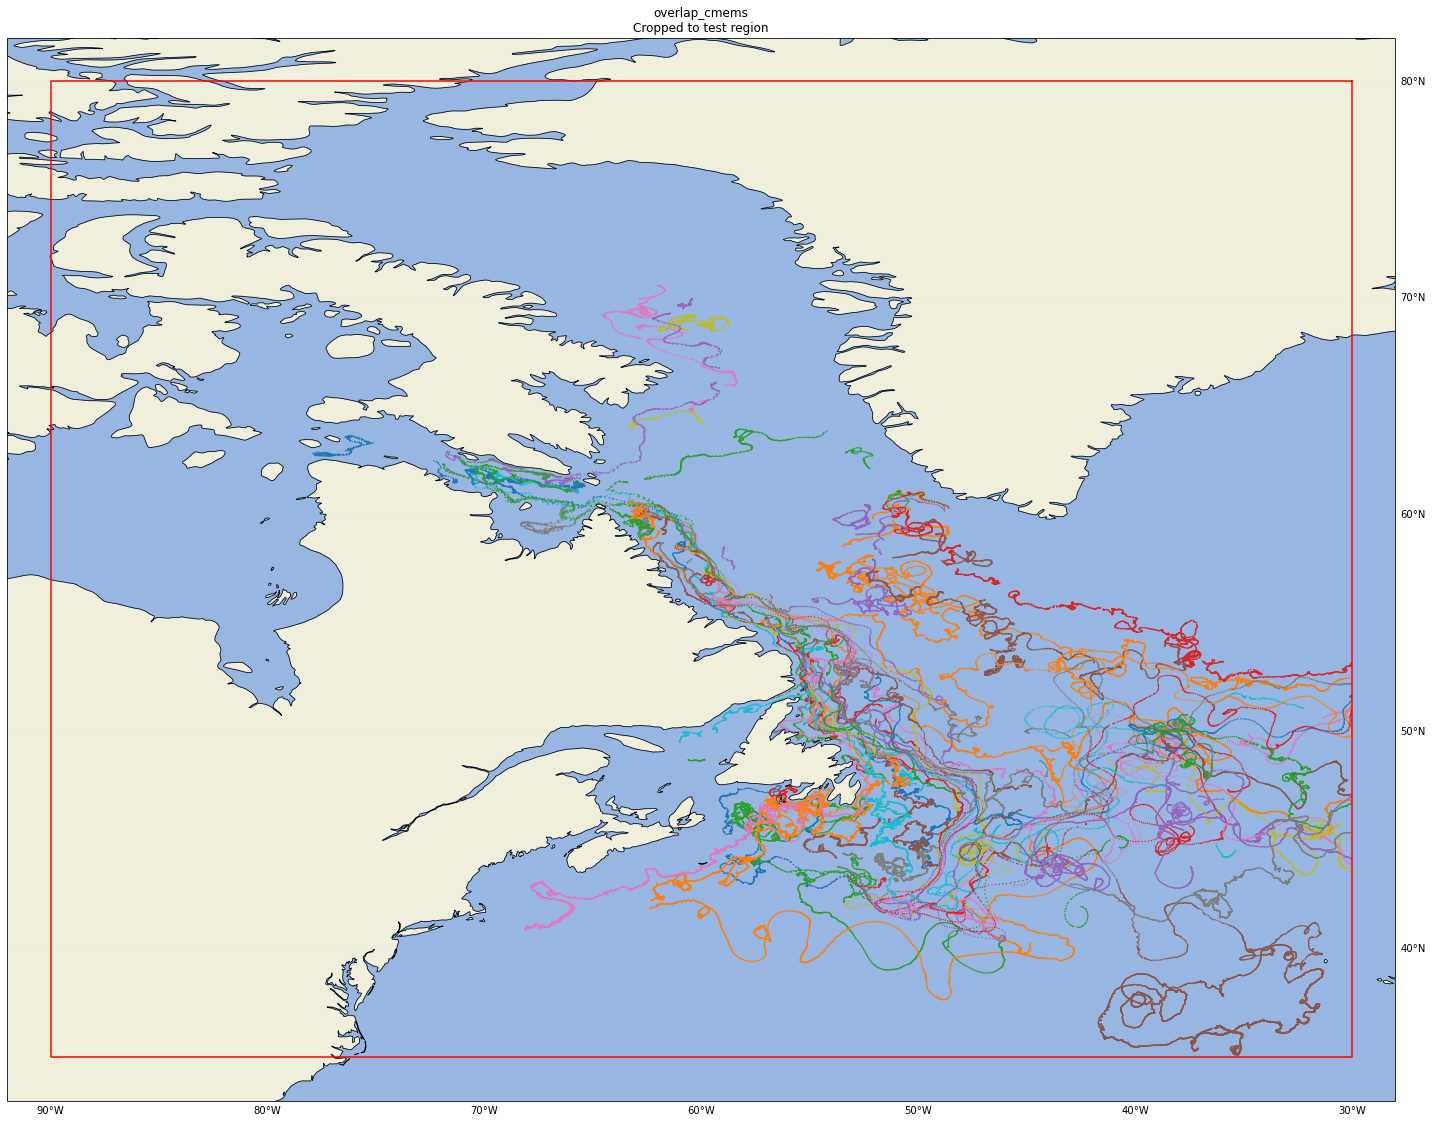

In [3]:
explore_data(
    'overlap_cmems', 
    get_files_list(overlap_dir, "overlap_hist048"), 
    overlap_dir, 
    shelf_coords, 
    use_dsdict_pickle=True, 
    use_masterdf_pickle=True,
    zoom_plot=True
)

# NAFC files that are in the CMEMS dataset

loading datasets from files and creating pickled list of datasets

419196 of 713621 points are in the region (58.7%) after removing any points smaller or larger than test region extremes

Summary
---------

There were 48 tracks (including 713621 total points) originally covering times from 2015-07-29 to 2019-08-29.
48 tracks (including 419196 points) are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2015-07-29 to 2019-08-29



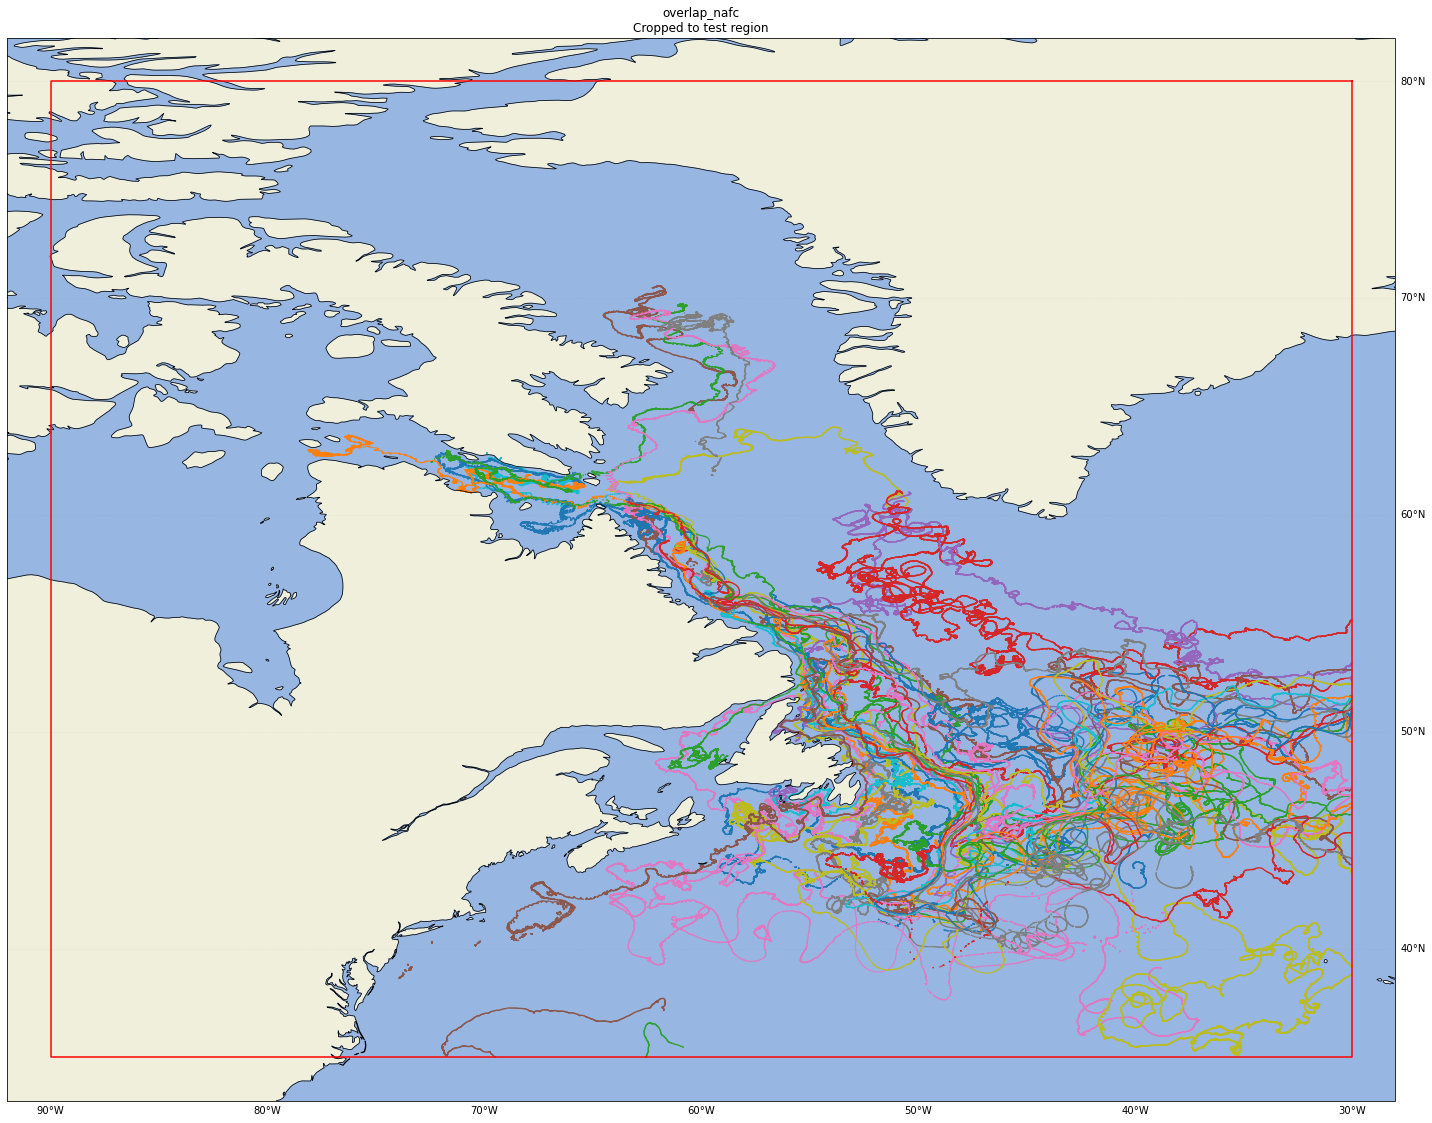

In [4]:
explore_data(
    'overlap_nafc', 
    get_files_list(overlap_dir, "overlap_nafc"), 
    overlap_dir, 
    shelf_coords, 
    use_dsdict_pickle=False, 
    use_masterdf_pickle=False,
    zoom_plot=True
)

# data included in NAFC but missing from CMEMS

31178 of 72671 points are in the region (42.9%) after removing any points smaller or larger than test region extremes

Summary
---------

There were 5 tracks (including 72671 total points) originally covering times from 2015-11-05 to 2019-08-29.
5 tracks (including 31178 points) are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2015-11-05 to 2017-11-14



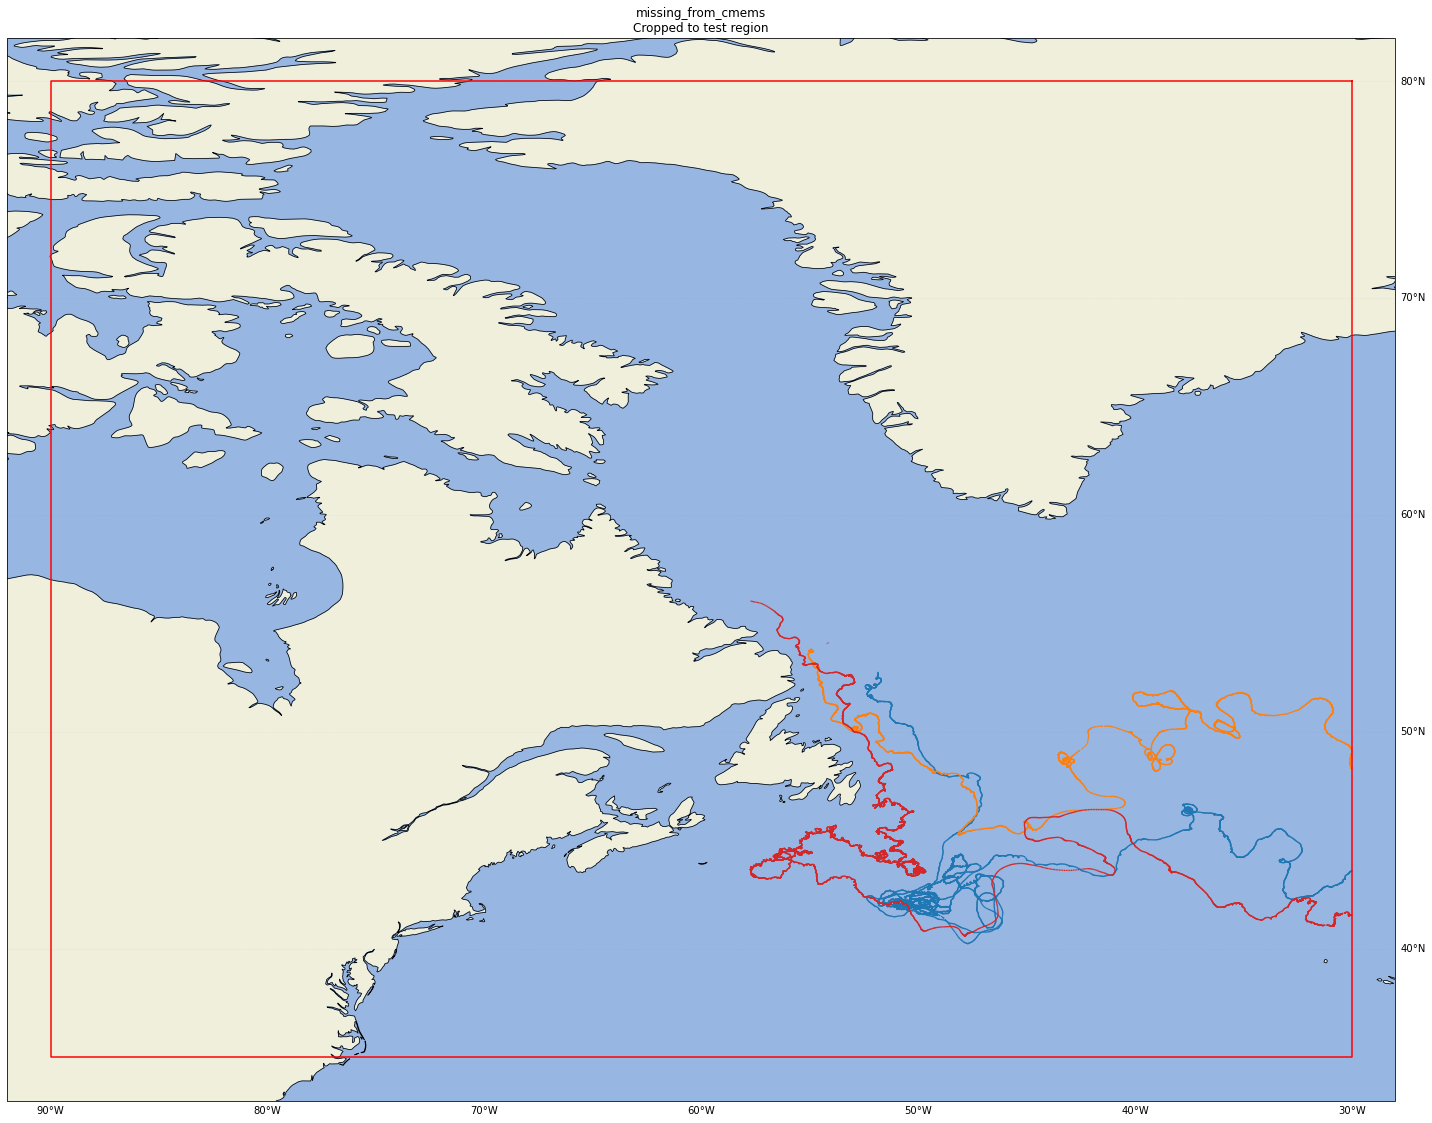

In [5]:
explore_data(
    'missing_from_cmems', 
    get_files_list(overlap_dir, "missing_from_cmems"), 
    overlap_dir, 
    shelf_coords, 
    use_dsdict_pickle=True, 
    use_masterdf_pickle=True,
    zoom_plot=True
)

# Comparing individual data files between the two datasets

In [28]:
def plot_single_track(ds, tstr, shelf_coords, teleid, wmoid, plot_type=None, deppts=None, include_bbox=False, savedir=None):
       
    plt.figure(figsize=(20, 20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
    
    if include_bbox:
        shelf_edges = determine_shelf_edges(shelf_coords)
        slons = list(zip(*shelf_edges))[0]
        slats = list(zip(*shelf_edges))[1]
        ax.plot(slons, slats, 'r-')

    if plot_type == 'markers':
        ax.plot(wrap_to_180(ds.LONGITUDE.values), ds.LATITUDE.values, 'k.', markersize=0.5, label='_no_label_')
    else:
        ax.plot(wrap_to_180(ds.LONGITUDE.values), ds.LATITUDE.values, '-', linewidth=1, label='_no_label_')
    
    if deppts:
        for pt, num in zip(deppts, range(0, len(deppts))):
            # example: ('48W43.36', '60N16.42')
            lon = -1 * (float(pt[0].split('W')[0]) + (float(pt[0].split('W')[1]))/60)
            lat = float(pt[1].split('N')[0]) + (float(pt[1].split('N')[1]))/60
            ax.plot(lon, lat, '.', markersize=20, markeredgecolor='w', label=('dep. location ' + str(num + 1) + ' (from spreadsheet)'))
        
    titlestr = tstr.split('_')[1]
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    plt.title(titlestr + '\nTelecom ID ' + str(teleid) + ' (WMO id' + str(wmoid) + ')')
    ax.legend(fontsize=12)
    
    if savedir is not None and os.path.isdir(savedir):
        savestr = (titlestr + "_TID" + str(teleid) + "_WID" + str(wmoid) + ".png")
        if plot_type == 'markers':
            savestr = savestr + "_markers"
        plt.savefig(os.path.join(savedir, (savestr + ".png")))

    plt.show()
    
    
def check_for_redeployed_files(overlap_dir, subfolder, teleid, wmoid, shelf_coords, 
                               plot_type=None, deppts=None, savedir=None):
    testfiles = get_files_list(overlap_dir, subfolder)
    testfile = [f for f in testfiles if teleid in f]
    if not testfile:
        testfile = [f for f in testfiles if wmoid in f]
    try:
        bname = os.path.basename(testfile[0])
    except:
        print('There is no file?')
    fname = os.path.join(overlap_dir, subfolder, bname)
    print('\nReading data from file ' + os.path.basename(fname) + '\n')
    with xr.load_dataset(fname) as ds:
        print('data start time:', min(ds.TIME.values))
        print('data end time:  ', max(ds.TIME.values), '\n')
        print_formatted_dataset_info(ds)
        #print(ds)
    plot_single_track(ds, subfolder, shelf_coords, teleid, wmoid, plot_type=plot_type, deppts=deppts, 
                      include_bbox=False, savedir=savedir)
    return ds

# A drifter that was redeployed, and that shows up in both the NAFC and CMEMS datafiles:


From spreadsheet:
-----------------------------------------------------

First deployment: 5/12/2016 (60 N 16.42, 48 W 43.36)
Second deployment: 11/24/2016 (51 N 23.8, 54 W 53.1)

Deployment note: beached in Northern Penisula and landed from about Oct. 28-Nov. 28th, 2016. Redeployed by multispecies survey nov. 2016; May 1, 2018 inactive for 9 days, VBAT 8, check in 2 weeks and deactivate if not responding: DEACTIVATED May 15, 2018



From the NAFC file:
-----------------------------------------------------

Reading data from file nafc300234063261890D20160517.nc

data start time: 2016-05-17T13:00:00.000000000
data end time:   2018-04-22T09:00:00.000000008 

Coordinates:
  * TIME     (TIME) datetime64[ns] 2016-05-17T13:00:00 ... 2018-04-22T09:00:0... 

Data variables:
    LATITUDE   (TIME) float64 60.97 60.98 60.98 60.99 ... 40.48 40.49 40.5 40.51
    LONGITUDE  (TIME) float64 -50.85 -50.86 -50.87 ... -46.04 -46.03 -46.02

Dimensions
  TIME: 16898

Attributes:
  source: retrieved from f

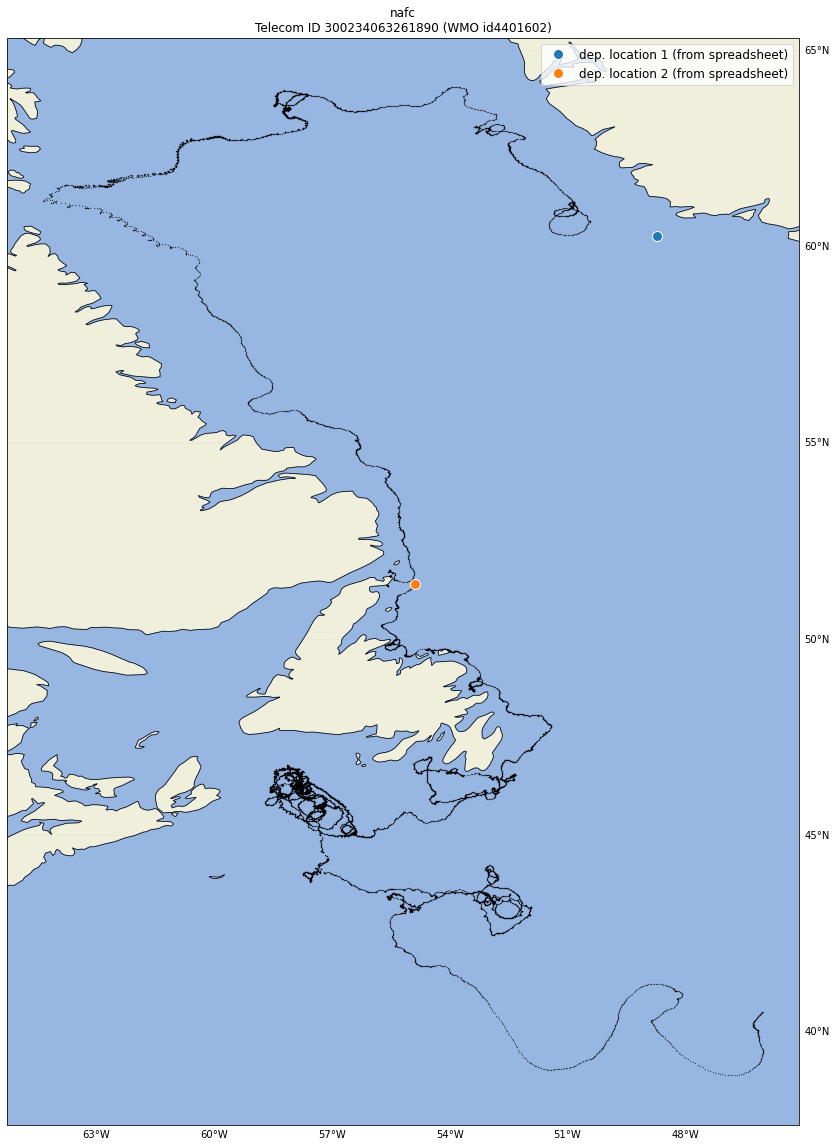




From the CMEMS file:
-----------------------------------------------------

Reading data from file GL_TS_DC_4401602.nc

data start time: 2016-05-12T12:00:00.000000000
data end time:   2018-04-22T08:00:00.000000000 

Coordinates:
  * TIME       (TIME) datetime64[ns] 2016-05-12T12:00:00 ... 2018-04-22T08:00:00
  * LATITUDE   (LATITUDE) float32 60.34 60.41 60.46 60.48 ... 40.48 40.49 40.5
  * LONGITUDE  (LONGITUDE) float32 -48.78 -48.8 -48.81 ... -46.05 -46.04 -46.03 

Data variables:
    TIME_QC             (TIME) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    POSITION_QC         (POSITION) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    POSITIONING_SYSTEM  (POSITION) object nan nan nan nan ... nan nan nan nan
    DC_REFERENCE        (TIME) object b'892532962                       ' ......
    DEPH                (TIME, DEPTH) float32 0.0 0.5 15.0 0.0 ... 0.5 15.0 nan
    DEPH_QC             (TIME, DEPTH) float32 7.0 7.0 1.0 7.0 ... 7.0 1.0 nan
    DEPH_DM             (TIME, DEPT

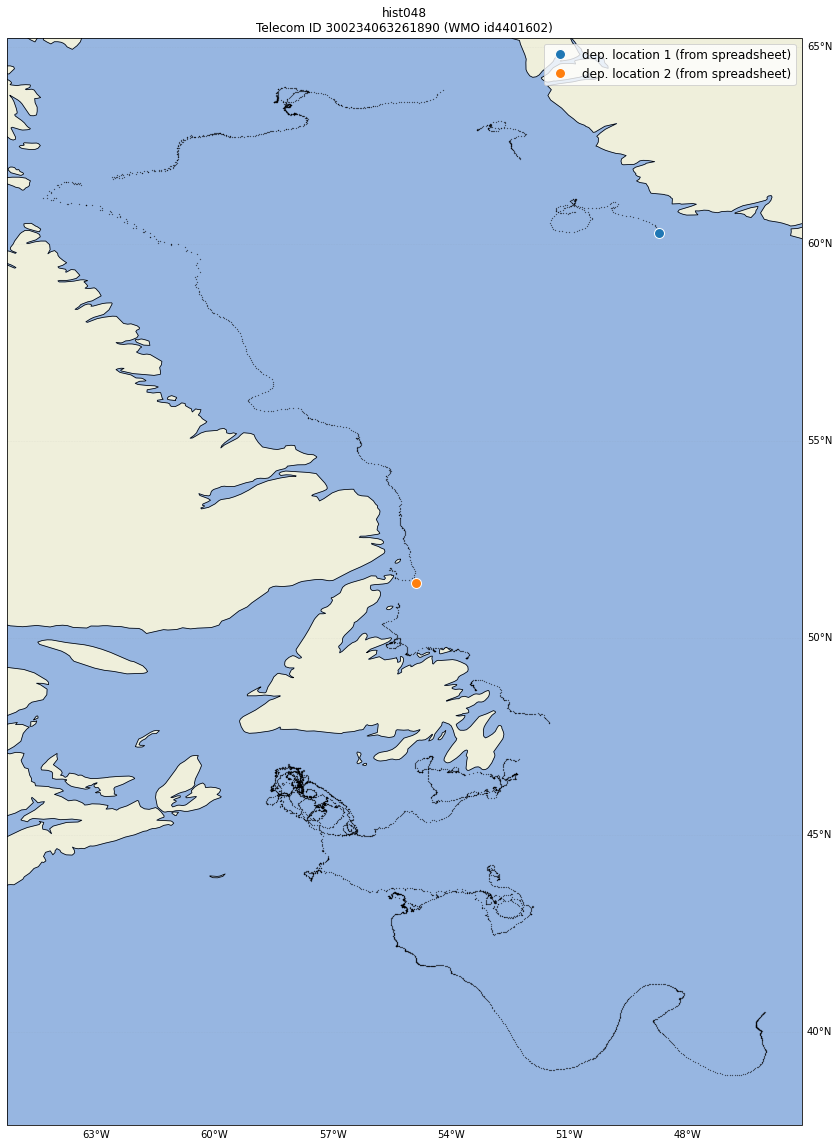

In [234]:
teleid = "300234063261890"
wmoid = "4401602"
deployment_points = [('48W43.36', '60N16.42'), ('54W53.1', '51N23.8')]


print('\nFrom spreadsheet:\n-----------------------------------------------------\n')
print('First deployment: 5/12/2016 (60 N 16.42, 48 W 43.36)')
print('Second deployment: 11/24/2016 (51 N 23.8, 54 W 53.1)')
print('\nDeployment note: beached in Northern Penisula and landed from about Oct. 28-Nov. 28th, 2016. ' 
      + 'Redeployed by multispecies survey nov. 2016; May 1, 2018 inactive for 9 days, VBAT 8, check ' 
      + 'in 2 weeks and deactivate if not responding: DEACTIVATED May 15, 2018\n')

print('\n\nFrom the NAFC file:\n-----------------------------------------------------')
ds = check_for_redeployed_files(overlap_dir, "overlap_nafc", teleid, wmoid, shelf_coords, 
                                plot_type='markers', 
                                deppts=deployment_points, 
                                savedir=os.path.join(overlap_dir, "plots"))
print('\n\n\nFrom the CMEMS file:\n-----------------------------------------------------')
ds = check_for_redeployed_files(overlap_dir, "overlap_hist048", teleid, wmoid, shelf_coords, 
                                plot_type='markers', 
                                deppts=deployment_points, 
                                savedir=os.path.join(overlap_dir, "plots"))

# A drifter that was redeployed, but that does NOT show up in the CMEMS data files (only in the NAFC data files)


From spreadsheet:
-----------------------------------------------------
First deployment: 7/20/2015 (54 N 29.78, 53 W 30.20)
Second deployment: 12/01/2015 (52 N 43.34, 53 W 47.03)

First deployment note: Washed ashore; recovered and deployed on Hudson; deactivated on JCOMMOPS database
Second deployment note: Aug. 2, battery voltage down to 7v; no data transmission - recheck on Aug. 29); DEACTIVATED Aug. 29



From the NAFC file:
-----------------------------------------------------

Reading data from file nafc300234062853860D20150729.nc

data start time: 2015-07-29T15:00:00.000000000
data end time:   2017-07-21T21:00:00.000000008 

Coordinates:
  * TIME     (TIME) datetime64[ns] 2015-07-29T15:00:00 ... 2017-07-21T21:00:0... 

Data variables:
    LATITUDE   (TIME) float64 53.79 53.79 53.79 53.8 ... 43.72 43.72 43.72 43.72
    LONGITUDE  (TIME) float64 -53.6 -53.61 -53.62 ... -40.06 -40.05 -40.03

Dimensions
  TIME: 16685

Attributes:
  source: retrieved from ftp.joubeh.com
  descriptio

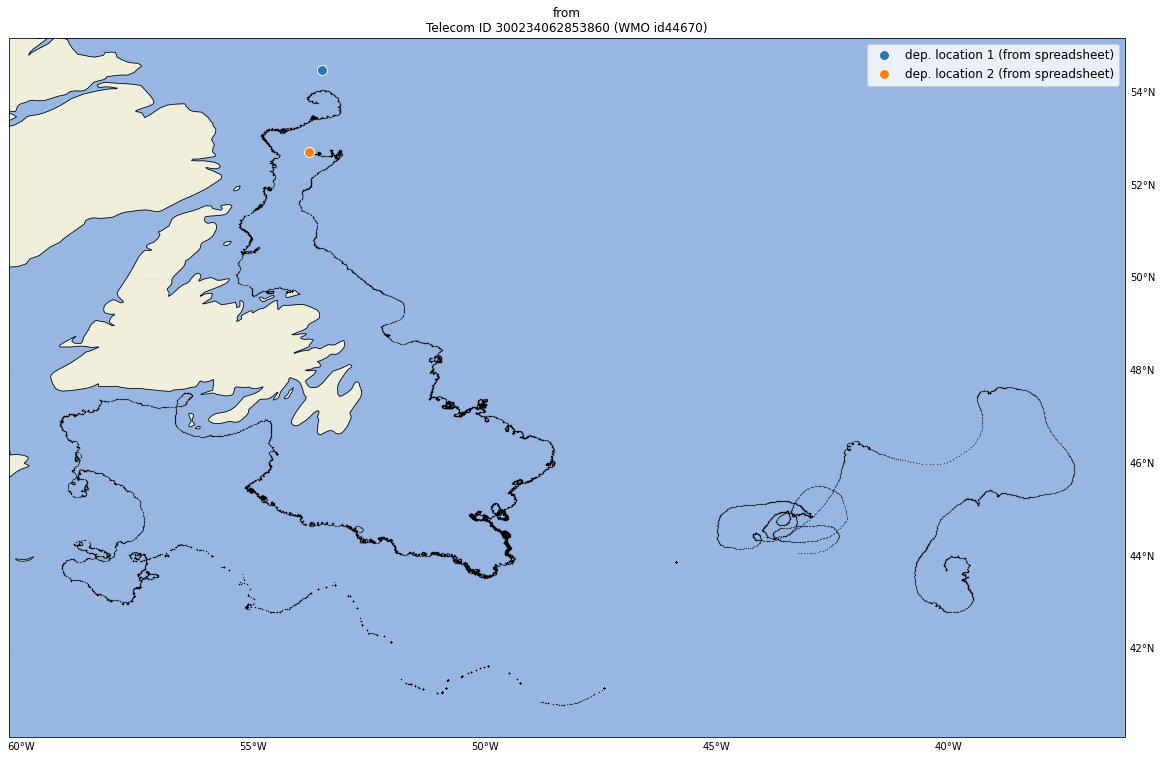

In [235]:
teleid = "300234062853860"
wmoid = "44670"
deployment_points = [('53W30.20', '54N29.78'), ('53W47.03', '52N43.34')]

print('\nFrom spreadsheet:\n-----------------------------------------------------')
print('First deployment: 7/20/2015 (54 N 29.78, 53 W 30.20)')
print('Second deployment: 12/01/2015 (52 N 43.34, 53 W 47.03)')
print('\nFirst deployment note: Washed ashore; recovered and deployed on Hudson; deactivated on JCOMMOPS database')
print('Second deployment note: Aug. 2, battery voltage down to 7v; no data transmission - recheck on Aug. 29); DEACTIVATED Aug. 29\n')

print('\n\nFrom the NAFC file:\n-----------------------------------------------------')
ds = check_for_redeployed_files(overlap_dir, "missing_from_cmems", teleid, wmoid, shelf_coords, 
                                plot_type='markers', 
                                deppts=deployment_points,
                                savedir=os.path.join(overlap_dir, "plots"))